# LFPCA through all conditions of anesthetized monkey

to run the monkey data through the analysis pipeline <br>
eyes open, eyes closed, and anesthesized <br>
write the code such that running through the notebook ONCE will reproduce all the results for all 3 datasets

visualize the results and compare the different conditions

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')

In [2]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import neurodsp as ndsp
from fooof import FOOOFGroup
from fooof import FOOOF
from scv_funcs import lfpca

In [5]:
data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"

In [42]:
nt_lfpca_monkey = np.empty(5,dtype=lfpca.LFPCA)

In [43]:
# example of using LFPCA
fs = 1000
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}
session_indices = [(1,0,1), (1,2,3), (2,1,2), (2,3,4), (3,0,1)]

for i, session_ind in enumerate(session_indices):
    session = session_ind[0]
    start_ind = session_ind[1]
    end_ind = session_ind[2]
    chan = range(1,129)
    # chan = [1,2]
    
    # with specified indices
    indices = asc.get_cond(data_path, session, start_ind, end_ind)
    data = asc.get_ECoG(data_path, session, chan, indices)

    # initialize object with data and parameters
    nt_lfpca = lfpca.LFPCA(analysis_param)
    nt_lfpca.populate_ts_data(data, fs)

    # compute all spectral attributes
    nt_lfpca.compute_all_spectral()

    # compute KS-test fit against null exponential hypothesis
    nt_lfpca.compute_KS_expfit() # this takes a few minutes
        
    nt_lfpca_monkey[i] = nt_lfpca

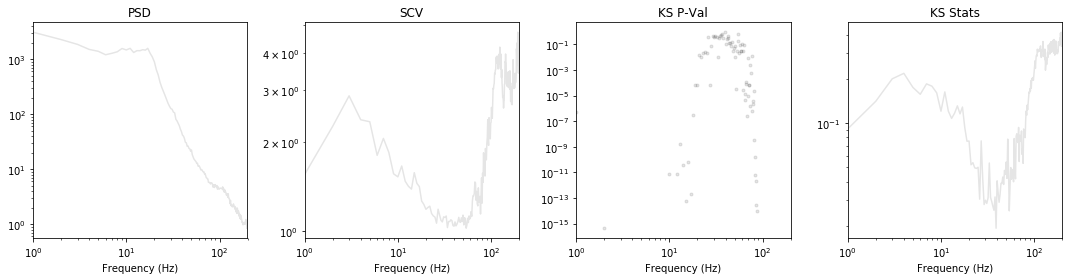

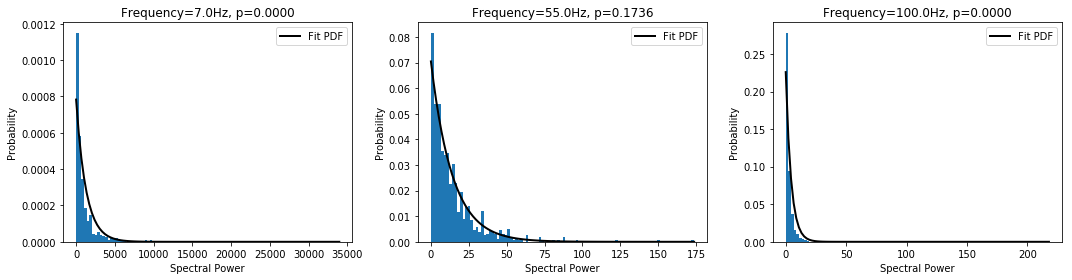

In [46]:
nt_lfpca_monkey[0].compute_KS_expfit()

plot_chan = 1

plt.figure(figsize=(15,4))
nt_lfpca_monkey[0].plot_spectral(plot_mean=False, plot_chan=plot_chan)

plot_freqs = [7,55,100]
plt.figure(figsize=(15,4))
for i,f in enumerate(plot_freqs):
    plt.subplot(1,3,i+1)
    nt_lfpca_monkey[0].plot_expfit(chan=plot_chan, freq_ind=f)

plt.tight_layout()

In [54]:
# fooof
def fooof_lfpca(nt_lfpca, background_mode, freq_range=[3,100]):
    fg = FOOOFGroup(background_mode=background_mode)
    fg.fit(nt_lfpca.f_axis, nt_lfpca.psd, freq_range)
    bg_params = [r.background_params for r in fg.get_results()]
    r2 = [r.r_squared for r in fg.get_results()]
    return bg_params, r2

In [55]:
# fooof lfpca
linear_bg_params, linear_r2 = fooof_lfpca(nt_lfpca_monkey[0],'fixed')
lz_bg_params, lz_r2 = fooof_lfpca(nt_lfpca_monkey[0],'knee')
noise_bg_params, noise_r2 = fooof_lfpca(nt_lfpca_monkey[0],'fixed', freq_range=[30,70])


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resoluti

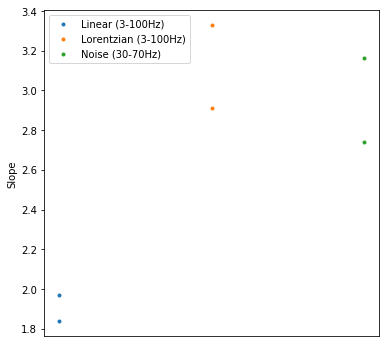

In [56]:
# compare fit slope parameters
slopes = np.array([[p[-1] for p in linear_bg_params], [p[-1] for p in lz_bg_params],[p[-1] for p in noise_bg_params]])
r2s = np.array([[r for r in linear_r2], [r for r in lz_r2],[r for r in noise_r2]])
labels = ('Linear (3-100Hz)','Lorentzian (3-100Hz)', 'Noise (30-70Hz)')
plt.figure(figsize=(6,6))
for i in range(3):    
    plt.plot(i*np.ones(nt_lfpca.numchan), slopes[i,:], '.', label=labels[i])

plt.xticks([])
plt.ylabel('Slope')
plt.legend()